# Classification of self-reflection reports
The first part preprocesses and processes the data and implements some simpler features, the second part trains and evaluates the classifiers.

In [90]:
#import packages for preprocessing and dataframe manipulation
import itertools
import numpy as np
import nltk
import pandas as pd
import math, string
import spacy
import pickle
import nltk
import re
import random
#import packages for stems, lemmas, POS tags...
from nltk.tag.sequential import ClassifierBasedTagger
from nltk.corpus import stopwords
from nltk.stem.cistem import Cistem 
from nltk.stem.snowball import GermanStemmer 
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#import packages for RFTagger
from subprocess import check_output, run
from nltk.tokenize import sent_tokenize, word_tokenize
#import packages for RAKE
import RAKE
#import packages for classifiers
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
import operator
#import packages for plotting
import seaborn as sn
import matplotlib.pyplot as plt

# First part: Feature Extraction

## -- only run the following lines if you don't have the preprocessed .xlsx (df_sentences_complete.xlsx & df_paragraphs_complete.xlsx) files in your local directory (preparing dataframe) --

In [34]:
#reading in the data, creating and manipulating the dataframe for paragraphs as instances
rawdf = pd.read_excel('annotierte_textpassagen_kombiniert.xlsx')
rawdf = rawdf.drop(["Kommentar", "Autor", "Erstellt am", "Gewicht", "Dokumentgruppe", "Farbe", "Fläche", "Abdeckungsgrad %"], axis=1)
transform = dict(enumerate(rawdf.Code.unique()))
transform = {v:k  for k,v in transform.items()}
rawdf.Code.replace(transform, inplace = True)

In [35]:
#creating and manipulating the dataframe for sentences as instances
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
df = pd.DataFrame()
for paragraph in enumerate(rawdf.Segment):
    for sentence in tokenizer.tokenize(paragraph[1]):
        df = df.append({"Dokumentname": rawdf.Dokumentname[paragraph[0]], "Code" : int(rawdf.Code[paragraph[0]]), 
                              "Segment" : sentence, "Anfang" : rawdf.Anfang[paragraph[0]], 
                              "Ende" : rawdf.Ende[paragraph[0]]}, ignore_index=True)
df.Code = df.Code.astype(int)

In [17]:
#building a part-of-speech tagger for German from this manual: 
#https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/
corp = nltk.corpus.ConllCorpusReader('.', 'tiger_release_aug07.corrected.16012013.conll09',
                                     ['ignore', 'words', 'ignore', 'ignore', 'pos'],
                                     encoding='utf-8')

tagged_sents = list(corp.tagged_sents())
random.shuffle(tagged_sents)


class ClassifierBasedGermanTagger(ClassifierBasedTagger):

    def feature_detector(self, tokens, index, history):

        word = tokens[index]
        if index == 0: # At the beginning of the sentence
            prevword = prevprevword = None
            prevtag = prevprevtag = None
            #word = word.lower() # Lowercase at the beginning of sentence
        elif index == 1:
            prevword = tokens[index-1] # Note: no lowercase
            prevprevword = None
            prevtag = history[index-1]
            prevprevtag = None
        else:
            prevword = tokens[index-1]
            prevprevword = tokens[index-2]
            prevtag = history[index-1]
            prevprevtag = history[index-2]

        if re.match('[0-9]+([\.,][0-9]*)?|[0-9]*[\.,][0-9]+$', word):
            # Included "," as decimal point
            shape = 'number'
        elif re.compile('\W+$', re.UNICODE).match(word):
            # Included unicode flag
            shape = 'punct'
        elif re.match('([A-ZÄÖÜ]+[a-zäöüß]*-?)+$', word):
            # Included dash for dashed words and umlauts
            shape = 'upcase'
        elif re.match('[a-zäöüß]+', word):
            # Included umlauts
            shape = 'downcase'
        elif re.compile("\w+", re.UNICODE).match(word):
            # Included unicode flag
            shape = 'mixedcase'
        else:
            shape = 'other'

        features = {
            'prevtag': prevtag,
            'prevprevtag': prevprevtag,
            'word': word,
            'word.lower': word.lower(),
            'suffix3': word.lower()[-3:],
            'preffix1': word[:1], 
            'prevprevword': prevprevword,
            'prevword': prevword,
            'prevtag+word': '%s+%s' % (prevtag, word),
            'prevprevtag+word': '%s+%s' % (prevprevtag, word),
            'prevword+word': '%s+%s' % (prevword, word),
            'shape': shape
            }
        return features
    
tagger = ClassifierBasedGermanTagger(train=tagged_sents)

In [18]:
#function for extracting the following features: lemmas, stems, POS tags
def features(paragraph):
    
    nlp = spacy.load('de')    
    lemmas = ""
    pos = ""
    stems = ""
    stems2 = ""
    
    doc = nlp(paragraph)
    stemmer1 = Cistem()
    stemmer2 = GermanStemmer()

    for token in doc:
        lemmas += token.lemma_
        lemmas += " "
        
    doc2 = paragraph.split()
    
    lst = tagger.tag(doc2)
    for tple in lst:
        pos += tple[1]
        pos += " "
    for token in doc2:

        stem1, stem2 = stemmer1.segment(token)
        stems += stem1
        stems += " "
        if len(stem2) != 0:
            stems += stem2
            stems += " "
        
        stems2 += stemmer2.stem(token)
        stems2 += " " 
        
    return lemmas, stems, stems2, pos

In [36]:
#extracting some features for the dataframe with sentences as instances
lemmalst = []
stemlst = []
stem2lst = []
poslst = []
sen_length = []
word_length = []
for report in df["Segment"]:
    lemmas, stems, stems2, pos = features(report)
    lemmalst.append(lemmas)
    stemlst.append(stems)
    stem2lst.append(stems2)
    poslst.append(pos)
    sen_length.append(len(report))
    word_length.append(sum(len(word) for word in report.split()) / len(report.split()))
    
    
df["Lemmas"] = np.array(lemmalst)
df["Stems"] = np.array(stemlst)
df["Stems2"] = np.array(stem2lst)
df["POS"] = np.array(poslst)
df["Sen_Length"] = np.array(sen_length)
df["Word_Length"] = np.array(word_length)
df.head()

,Anfang,Code,Dokumentname,Ende,Segment,Lemmas,Stems,Stems2,POS,Sen_Length,Word_Length
0,11.0,0,R_A8_1,13.0,Diese Stunde war für mich die erste selbstgege...,Diese Stunde sein für sich der erste selbstgeg...,dies e stund e war für mich die ers te selbstg...,dies stund war fur mich die erst selbstgegeb s...,PDAT NN VAFIN APPR PPER ART ADJA ADJA NN APPRA...,76,6.000000
1,11.0,0,R_A8_1,13.0,Sie fand direkt nach den Osterferien am Montag...,ich finden direkt nach der Osterferien am Mont...,sie fand direk t nach den osterferie n am mont...,sie fand direkt nach den osterferi am montag s...,PPER VVFIN ADJD APPR ART NN APPRART NN PPOSAT,53,5.000000
2,11.0,0,R_A8_1,13.0,Die Unterrichtsstunden sind an der Schule in d...,der Unterrichtsstunden sein an der schulen in ...,die unterrichtsstu nden sind an der schul e in...,die unterrichtsstund sind an der schul in der ...,ART NN VAFIN APPR ART NN APPR ART NN APPR ART ...,84,6.083333
3,11.0,0,R_A8_1,13.0,In der ersten Stunde wurde noch ein Test zum v...,In der erst Stunde werden noch einen Test zum ...,in der ers ten stund e wurd e noch ein test zu...,in der erst stund wurd noch ein test zum vorhe...,APPR ART ADJA NN VAFIN ADV ART NN APPRART ADJA...,74,5.250000
4,11.0,0,R_A8_1,13.0,Da die SuS für diesen Test etwas mehr als 45 m...,da der SuS für dies Test etwas mehr als 45 min...,da die sus für dies en test etwa s mehr als 45...,da die sus fur dies test etwas mehr als 45 min...,KOUS ART NE APPR PDAT NN ADV PIAT KOKOM CARD P...,123,4.391304


In [37]:
#extracting some features for the dataframe with paragraphs as instances
lemmalst = []
stemlst = []
stem2lst = []
poslst = []
sen_length = []
word_length = []

for report in rawdf["Segment"]:
    lemmas, stems, stems2, pos = features(report)
    lemmalst.append(lemmas)
    stemlst.append(stems)
    stem2lst.append(stems2)
    poslst.append(pos)
    sen_length.append(len(report))
    word_length.append(sum(len(word) for word in report.split()) / len(report.split()))
    
rawdf["Lemmas"] = np.array(lemmalst)
rawdf["Stems"] = np.array(stemlst)
rawdf["Stems2"] = np.array(stem2lst)
rawdf["POS"] = np.array(poslst)
rawdf["Sen_Length"] = np.array(sen_length)
rawdf["Word_Length"] = np.array(word_length)
rawdf.head()

,Dokumentname,Code,Segment,Anfang,Ende,Lemmas,Stems,Stems2,POS,Sen_Length,Word_Length
0,R_A8_1,0,Diese Stunde war für mich die erste selbstgege...,11,13,Diese Stunde sein für sich der erste selbstgeg...,dies e stund e war für mich die ers te selbstg...,dies stund war fur mich die erst selbstgegeb s...,PDAT NN VAFIN APPR PPER ART ADJA ADJA NN APPRA...,1427,5.735849
1,R_A8_1,1,"Ich wiederholte, dass im Magnetfeld auf einen ...",15,17,"ich wiederholen , dass im Magnetfeld auf ein s...","ich wiederholte, dass im magnetfeld auf eine n...","ich wiederholte, dass im magnetfeld auf ein st...",PPER VAFIN PROAV APPRART NN APPR ART ADJA NN A...,2129,5.870968
2,R_A8_1,2,Insgesamt bin ich sehr zufrieden mit dem Einst...,19,19,Insgesamt sein ich sehr zufrieden mit der Eins...,insgesamt bin ich sehr zufried en mit dem eins...,insgesamt bin ich sehr zufried mit dem einstie...,ADV VAFIN PPER ADV ADJD APPR ART NN PPOSAT ADJ...,209,5.562500
3,R_A8_1,2,"Ich wusste, dass es für Schüler anfangs schwie...",19,19,"ich wusste , dass ich für Schüler anfangs schw...","ich wusste, dass es für schüler anfang s schwi...","ich wusste, dass es fur schul anfang schwierig...",PPER VAFIN PROAV PPER APPR NN ADV ADJD VAINF V...,578,5.892857
4,R_A8_1,2,Mit diesem Ansatz wollte ich dann auf einen ve...,20,21,Mit dies Ansatz wollen ich dann auf ein veränd...,mit diesem ansatz woll te ich dann auf eine n ...,mit dies ansatz wollt ich dann auf ein verande...,APPR PDAT NN VMFIN PPER ADV APPR ART ADJA NN A...,683,5.840000


In [11]:
#save the dataframes to local directory
df.to_excel("DF_sentences_kombiniert.xlsx")
rawdf.to_excel("DF_paragraphs_kombiniert.xlsx")

## -- run from this line again if you have the preprocessed .xlsx files (df_sentences_complete.xlsx & df_paragraphs_complete.xlsx) already in your local directory (remaining feature implementation, classifier learning and evaluation) --

In [73]:
#Creating a pandas dataframe with all the given data
df_sent_unfinished = pd.read_excel("DF_sentences_kombiniert.xlsx")
df_par_unfinished = pd.read_excel("DF_paragraphs_kombiniert.xlsx")

# RF Tagger

In [2]:
#run RF Tagger
run(["make"], cwd="RFTagger/src")

CompletedProcess(args=['make'], returncode=2)

In [3]:
#Creating a helper function
def rftagger(text):
    """
    Helper function that tags the given text (sentences or paragraphs) with RFtagger.
    Args:
        text: a string of text.
    Returns:
        a string with the tagged words.
    """
    file = open("RFTagger/temp.txt", "w")
    file.write("\n\n".join("\n".join(word_tokenize(sentence, language='german'))\
                           for sentence in sent_tokenize(text, language='german')))
    file.close()
    test_tagged = check_output(["src/rft-annotate", "lib/german.par", "temp.txt"],\
                               cwd="RFTagger").decode("utf-8").split("\n")
    tagged_text = ''
    for word in test_tagged:
        tagged_text += word[word.find('\t') + 1:] + ' '
    return tagged_text

In [ ]:
#Creating a new column with tagged texts for each dataframe (sentences and paragraphs)
df_sent_unfinished['RFtagger'] = df_sent_unifinished.Segment.apply(rftagger)
df_par_unfinished['RFtagger'] = df_par_unifinished.Segment.apply(rftagger)

# RAKE Keyword Extraction

In [11]:
#Creating a RAKE object that doesn't take into account stopwords
rake_object = RAKE.Rake('stopwords_de.txt')

In [14]:
#Creating a helper function
def keywords(text):
    """
    Helper function that appends all the keywords given by the rake_object with a maximum of 20 keywords.
    Args:
        text: a string of text.
    Returns:
        a string with all keywords.
    """
    word = ''
    for pair in rake_object.run(text)[:20]:
        word += ' ' + pair[0]
    return word

In [ ]:
#Creating a new column with keywords for each dataframe (sentences and paragraphs)
df_sent_unfinished['Keywords'] = df_sent_unifinished.Segment.apply(keywords)
df_par_unfinished['Keywords'] = df_par_unifinished.Segment.apply(keywords)

In [ ]:
#Creating a new excel table with the new columns
df_sent_unfinished.to_excel("df_sentences_complete.xlsx")
df_par_unfinished.to_excel("df_paragraphs_complete.xlsx")

# Second part: Training and Evaluation

In [222]:
#Getting the final version dataframes
df_sent = pd.read_excel("df_sentences_complete.xlsx")
df_par = pd.read_excel("df_paragraphs_complete.xlsx")

## Classifiers

In [197]:
#creating the architecture of all classifiers to be used
"NAIVE BAYES"
naive_bayes = Pipeline([('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB(alpha = 0.05)),
              ])

"LINEAR SUPPORT VECTOR MACHINE"
linear_support_vector_machine = Pipeline([('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=42, shuffle = False)),
               ])

"LOGISTIC REGRESSION"
logistic_regression = Pipeline([('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1e2, solver = 'newton-cg'))
               ])

"RANDOM FOREST"
random_forest = Pipeline([('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(random_state = 42, class_weight = 'balanced')),
               ])

classifiers = {'naive bayes': naive_bayes, 'linear support vector machine': linear_support_vector_machine,
               'logistic regression' : logistic_regression, 'random forest' : random_forest}

## Training Classifiers

In [221]:
def test_clf(classifier, feature_list, dataframe, vector):
    results = {}
    if vector == True:
        word_counts = [CountVectorizer().fit_transform(dataframe[item].values.astype('U')).toarray()\
                       for item in feature_list]
        vectorized_features = np.concatenate(word_counts, axis = 1)
        results[tuple(feature_list)] = np.mean(cross_val_score(classifier, vectorized_features, dataframe.Code))
    if vector == False:
        if len(feature_list) == 1:
            appended_column = dataframe[feature_list[0]]
        else:
            appended_column  = dataframe[feature_list[0]].str.cat([dataframe[feature]\
                                                                   for feature in feature_list[1:]], sep = ' ')
        vectorized_column = CountVectorizer().fit_transform(appended_column.values.astype('U')).toarray()
        results[tuple(feature_list)] = np.mean(cross_val_score(classifier, vectorized_column,\
                                                               dataframe.Code, cv = KFold(shuffle = False)))
    return results

def feature_reduction(classifier, feature_list, dataframe, vector):
    results = test_clf(classifier, feature_list, dataframe, vector)
    for dummy in range(len(feature_list) - 1):
        temporary_results = {}
        for index in range(len(feature_list)):
            single_result = test_clf(classifier, feature_list[:index] + feature_list[index + 1:], dataframe, vector)
            temporary_results.update(single_result)
        current_result = {max(temporary_results.items(), key = operator.itemgetter(1))[0]:
                         max(temporary_results.items(), key = operator.itemgetter(1))[1]}
        results.update(current_result)
        feature_list = list(current_result.keys())[0]
    return results
                      

## Evaluation

In [223]:
#Testing all classifiers with all both feature representations (vectorized features and appended features) with sentences
# and paragraphs
results = {}
for key in classifiers:
    results[str(key)] = {}
    results[str(key)]['vector_sent'] = feature_reduction(classifiers[key], list(df_sent.columns[-7:]), df_sent, True)
    results[str(key)]['append_sent'] = feature_reduction(classifiers[key], list(df_sent.columns[-7:]), df_sent, False)
    results[str(key)]['vector_par'] = feature_reduction(classifiers[key], list(df_par.columns[-7:]), df_par, True)
    results[str(key)]['append_par'] = feature_reduction(classifiers[key], list(df_par.columns[-7:]), df_par, False)

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/miniconda3/lib/python3.7/si

/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/f

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_sele

/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/f

/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/f

/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/f

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_sele

/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/f

/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/f

/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/f

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_sele

/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/f

/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/f

In [224]:
#Transforming each of the 16 dictionary of results into a dataframe (4 classifiers by 4 feature representations)
dict_df_results = {}
for clf in results.keys():
    dict_df_results[clf] = {}
    for rep in results['naive bayes'].keys():
        dict_df_results[clf][rep] = pd.DataFrame.from_dict(results[clf][rep], orient = 'index')

In [225]:
#Getting the best performance and its feature combination for each combination of classifier and feature representation
data = {}
for clf in dict_df_results.keys():
    data[clf] = []
    for rep in dict_df_results['naive bayes'].keys():
        data[clf].append(dict_df_results[clf][rep][0].argmax())
        data[clf].append(dict_df_results[clf][rep][0].max())
max_results = pd.DataFrame.from_dict(data).transpose().rename(columns = {0: 'vector sent', 1: '', 2: 'append sent', 3: '',
                                                           4: 'vector par', 5: '', 6: 'append par', 7: ''})

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


In [146]:
#saving the dataframe into an Excel file
max_results.to_excel("Max results complete.xlsx")

## Results

In [145]:
#visualizing the results
max_results

,vector sent,,append sent,,vector par,,append par,
naive bayes,"(Segment, Stems, POS, RFtagger)",0.545513,"(Segment, Stems, POS, RFtagger)",0.55894,"(Segment, Stems)",0.650428,"(Segment, Stems)",0.645902
linear support vector machine,"(Segment, Lemmas, Stems, POS, Keywords)",0.536621,"(Stems, POS, RFtagger, Keywords)",0.545075,"(Segment, Lemmas, POS, RFtagger, Keywords)",0.667922,"(Stems2, RFtagger)",0.663388
logistic regression,"(Segment, Lemmas, Stems, Stems2, RFtagger)",0.559365,"(Segment, Stems2, RFtagger)",0.562024,"(Segment, Lemmas, Stems, RFtagger)",0.698538,"(Stems, POS, RFtagger)",0.672131
random forest,"(Segment, Lemmas, Stems2, POS, RFtagger, Keywo...",0.450745,"(Segment, Lemmas, Stems, Stems2, POS, RFtagger)",0.442222,"(Segment, Lemmas, Stems, Stems2, RFtagger, Key...",0.545671,"(Segment, Lemmas, Stems2, POS)",0.52459


## Confusion matrix of best result (logistic regression with vector paragraphs)

In [148]:
#Deviding the data into train and test sets in order to assess the performance of the best combination of classifier, 
#feature representation and feature combination 
word_counts = [CountVectorizer().fit_transform(df_par[item].values.astype('U')).toarray() \
               for item in ['Segment', 'Lemmas', 'Stems', 'RFtagger']]
vectorized_features = np.concatenate(word_counts, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(vectorized_features, df_par.Code, test_size=0.33, random_state=42)

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


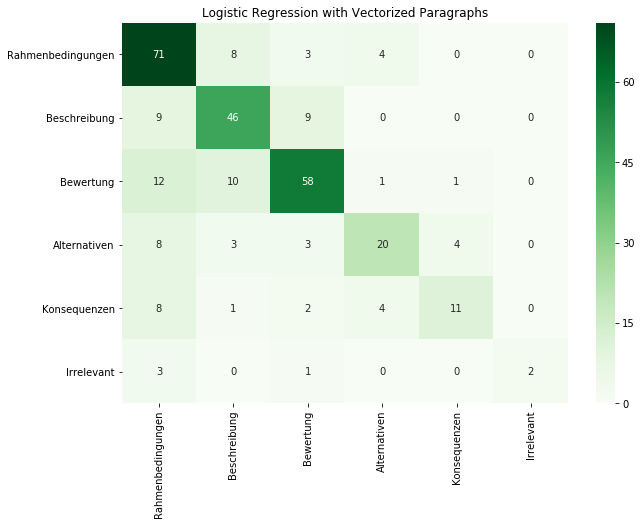

In [149]:
#Testing and plotting the confusion matrix of the best result
lg_vp = logistic_regression
lg_vp.fit(X_train, y_train)
df_cm = pd.DataFrame(confusion_matrix(y_test, lg_vp.predict(X_test)),
                        index = [name for name in df_par_unfinished.Code.unique()],
                        columns = [name for name in df_par_unfinished.Code.unique()])
plt.figure(figsize = (10,7))
plt.axes().set_title('Logistic Regression with Vectorized Paragraphs')
sn.heatmap(df_cm, cmap="Greens" ,annot=True)
plt.savefig('Confusion Matrix Logistic Regression & Vectorized Paragraphs.png')



## Classifying with position in text only

In [227]:
#shuffling the data for classification
np.random.seed(42)
df_sent = df_sent.reindex(np.random.permutation(df_sent.index))
np.random.seed(42)
df_par = df_par.reindex(np.random.permutation(df_par.index))

In [228]:
#training and testing the performance of all classifiers
position_results_sent = {}
for clf in classifiers:
    position_results_sent[clf] = test_clf(classifiers[clf], df_sent.columns[5:7], df_sent, True)[('Anfang', 'Ende')]
    
position_results_par = {}
for clf in classifiers:
    position_results_par[clf] = test_clf(classifiers[clf], df_par.columns[5:7], df_par, True)[('Anfang', 'Ende')]

/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", Fut

## Results using position in text only

In [229]:
#see results of sentence classification
position_results_sent

{'naive bayes': 0.4707284838937911,
 'linear support vector machine': 0.5712771496081913,
 'logistic regression': 0.5959181584767296,
 'random forest': 0.5824475919671424}

In [230]:
#se results of paragraph classification
position_results_par

{'naive bayes': 0.425136612021858,
 'linear support vector machine': 0.4502732240437159,
 'logistic regression': 0.4775956284153005,
 'random forest': 0.453551912568306}